# Break rate inference

# Setup

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools
plt.style.use('ggplot')
FIG_PATH = "./../../figures/"

## Load processed data

In [2]:
data= pd.read_csv('./../../experimental_data/processed_data/single_cell_data.csv')
data_avg = pd.read_csv('./../../experimental_data/processed_data/avg_data.csv')
experiments = data.experiment.unique()

In [34]:
data.time

0           0
1          20
2          40
3          60
4          80
         ... 
93971    1360
93972    1380
93973    1400
93974    1420
93975    1440
Name: time, Length: 93976, dtype: int64

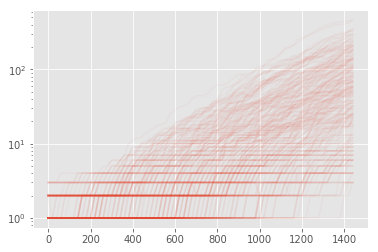

In [6]:
[plt.semilogy(data[(data.experiment=='NR-SpCas9') & (data.well==well)].time,\
 data[(data.experiment=='NR-SpCas9') & (data.well==well)].bf,alpha=0.04,color='C0') for well \
 in data[data.experiment=='NR-SpCas9'].well.unique()];

In [7]:
fits = pd.DataFrame()
fits['experiment'] =experiments
fits['defect'] = [data[data.experiment==exp].defect.values[0] for exp in experiments]
fits['nuclease'] = [data[data.experiment==exp].nuclease.values[0] for exp in experiments]

# Population fits

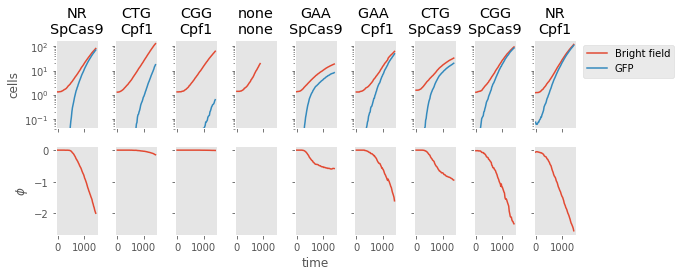

In [29]:
fig,axs = plt.subplots(ncols = len(experiments),nrows = 2,figsize=(10,4),sharex=True,sharey="row")
k = 0
for exp in experiments:
    ax= axs[0,k]
    if 'exp' != 'NoGuideRNA':
        ax.set_title(data_avg[data_avg.experiment== exp].defect.values[0]\
                     +'\n'+data_avg[data_avg.experiment== exp].nuclease.values[0])
    ax.semilogy(data_avg[data_avg.experiment == exp].time,data_avg[data_avg.experiment==exp].bf,\
                label="Bright field")
    ax.plot(data_avg[data_avg.experiment == exp].time,data_avg[data_avg.experiment==exp].gfp,\
            label="GFP")
    ax.grid(False)
    
    #
    ax= axs[1,k]
    ax.grid(False)
    bf = data_avg[data_avg.experiment==exp].bf.values
    gfp = data_avg[data_avg.experiment==exp].gfp.values
    lnphi = np.log(1-gfp/bf)
    ax.plot(data_avg[data_avg.experiment== exp].time.values,lnphi)
  
    k +=1
    
axs[0,0].set_ylabel(r'cells')
axs[1,0].set_ylabel(r'$\phi$')
axs[0,-1].legend(frameon=True,bbox_to_anchor=(1.05, 1))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.grid(False)
plt.tight_layout()
plt.xlabel('time');
plt.savefig(FIG_PATH+"bulk_data.pdf",bbox_inches = "tight")

In [31]:
def fit_population_alpha(experiment): 
    time = data_avg[data_avg.experiment==experiment].time.values
    bf = data_avg[data_avg.experiment==experiment].bf.values
    gfp = data_avg[data_avg.experiment==experiment].gfp.values
    
    times_middle = time[int(2*len(time)//4):int(3*len(time)//4)]
    bf_middle = bf[int(2*len(time)//4):int(3*len(time)//4)]
    
    results = stats.linregress(times_middle, np.log(bf_middle))
    alpha = results.slope
    return alpha

def fit_population_beta(experiment):
    time = data_avg[data_avg.experiment==experiment].time.values
    bf = data_avg[data_avg.experiment==experiment].bf.values
    gfp = data_avg[data_avg.experiment==experiment].gfp.values
    lnphi = np.log(1-gfp/bf)
    
    times_middle = time[int(2*len(time)//4):int(3*len(time)//4)]
    lnphi_middle = lnphi[int(2*len(time)//4):int(3*len(time)//4)]
    
    results = stats.linregress(times_middle, lnphi_middle)
    beta = -results.slope
    return beta

In [32]:
fits['alpha_population'] = [fit_population_alpha(exp) for exp in experiments]
fits['beta_population']  = [fit_population_beta(exp) for exp in experiments]
fits

,experiment,defect,nuclease,alpha_population,beta_population
0,NR-SpCas9,NR,SpCas9,0.003853,0.001968
1,CTG-Cpf1,CTG,Cpf1,0.003870,0.000103
2,CGG-Cpf1,CGG,Cpf1,0.003575,0.000011
3,NoGuideRNA,none,none,0.004020,NaN
4,GAA-SpCas9-comb,GAA,SpCas9,0.001823,0.000333
5,GAA - Cpf1,GAA,Cpf1,0.003784,0.001377
6,CTG-SpCas9-comb,CTG,SpCas9,0.002480,0.000913
7,CGG-SpCas9,CGG,SpCas9,0.003871,0.002027
8,NR-Cpf1-comb,NR,Cpf1,0.004104,0.002268


In [76]:
np.log(2)/0.07

9.902102579427789

# Single Cell fits

## Non-bayesian point estimates

In [17]:
def get_jumps(t,m,r):
    """
    get information about jump times (times when the number of cells changes)

    Input:
        t      -  the list of times
        m      -  number of modified cells
        r      -  number of repaired cells

    Output:
        T   - the total "cell-cycle time" until the appearence of first gfp cell
        jump_times

    """
    ind_gfp = np.argmax(r>0)
    k = 1
    i_gfp =0 # index of gfp in jump_cells
    jump_times = []
    jump_cells = []
    while k< len(m):
        dm = m[k]-m[k-1]
        if dm>0:
            jump_times.append(t[k])
            jump_cells.append(m[k])
            if k <= ind_gfp:
                i_gfp+=1
        k+=1

    jump_times.append(t[-1])
    jump_times = np.array(jump_times)
    jump_cells = np.array(jump_cells)
    taus = jump_times[1:]-jump_times[:-1]
    if i_gfp>0:
        T = np.sum(jump_cells[:i_gfp]*taus[:i_gfp])
    else:
        T = 0.
    return T,jump_times[:-1],jump_cells[:-1],taus,i_gfp

In [26]:
def per_division_break(experiment):
    """
    infer break rate assuming that breaks don't happen during lag
    """
    
    if experiment != 'NoGuideRNA':
        data_exp = data[data.experiment==experiment]
        time = data[data.well == data.well[0]].time.values
        wells = data_exp.well.unique()
        D = []
        Tmax = []
        for well in wells:
            bf = data_exp[data_exp.well==well].bf.values
            gfp = data_exp[data_exp.well==well].gfp.values
            Ti,jump_times,jump_cells,taus,i_gfp = get_jumps(time,bf,gfp)
            Tmaxi = np.dot(jump_cells,taus[:-1])
            if i_gfp>0 and Tmaxi>Ti:
                D.append((jump_cells[1:]-jump_cells[:-1])[i_gfp-1])
                Tmax.append(Tmaxi)

        return np.mean([1/(d+1) for d in D if d>0])*fits[fits.experiment==experiment].alpha_population.values[0]*2
    else:
        return np.nan


def constant_break_rate(experiment):
    """
    infer break rate assuming that breaks don't happen during lag
    """


    if experiment != 'NoGuideRNA':
        data_exp = data[data.experiment==experiment]
        time = data[data.well == data.well[0]].time.values
        wells = data_exp.well.unique()
        D = []
        Tmax = []
        T = []
        for well in wells:
            bf = data_exp[data_exp.well==well].bf.values
            gfp = data_exp[data_exp.well==well].gfp.values
            Ti,jump_times,jump_cells,taus,i_gfp = get_jumps(time,bf,gfp)
            Tmaxi = np.dot(jump_cells,taus[:-1])
            if i_gfp>0 and Tmaxi>Ti:
                T.append(Ti)
                Tmax.append(Tmaxi)


        return np.mean(1/np.array(T))
    else:
        return np.nan

In [27]:
fits['beta_pdb']= [per_division_break(exp) for exp in experiments]
fits['beta_cbr']= [constant_break_rate(exp) for exp in experiments]

(0, 0.004)

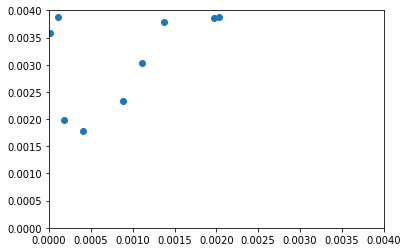

In [28]:
plt.plot(fits.beta_population,fits.alpha_population,'o')
ax = plt.gca()
ax.set_ylim([0,0.004])
ax.set_xlim([0,0.004])

In [33]:
fits.to_csv('./output/fits_summary.csv')

Text(0, 0.5, 'Population')

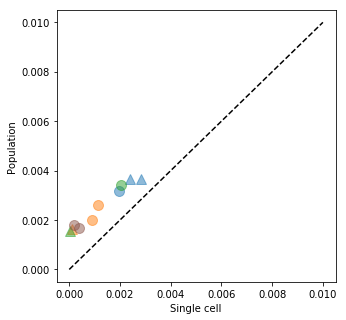

In [31]:
markers = ['o','^','>','-','*','+']
colors = ['C0','C1','C2','C3','C4','C5']
fig,ax = plt.subplots(figsize=(5,5),sharex=True,sharey=True)
for defect in fits.defect.unique():
    for nuclease in fits.nuclease.unique():
        marker = markers[list(fits.nuclease.unique()).index(nuclease)]
        color = colors[list(fits.defect.unique()).index(defect)]
        df = fits[fits.defect==defect]
        df = df[df.nuclease==nuclease]
        ax.plot(df.beta_population,df.beta_pdb,marker,color=color,markersize=10,alpha=0.5)
rang = np.linspace(0,0.01,2)
ax.plot(rang,rang,'k--')
ax.set_xlabel('Single cell')
ax.set_ylabel('Population')
#ax.set_ylim([0.,0.0035])
#ax.set_xlim([0.,0.0035])

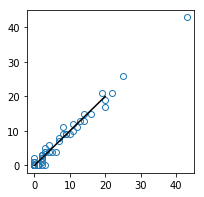

In [78]:
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(dbf,dg,'o',fillstyle='none')
ax.plot(np.linspace(0,20,3),np.linspace(0,20,3),'k-')
#plt.plot(dg,'o',fillstyle='none')

In [65]:
data.experiment.unique()

array(['NR-SpCas9', 'CTG-Cpf1', 'CGG-Cpf1', 'NoGuideRNA', 'CTG-SpCas9-1',
       'GAA - Cpf1', 'CTG-SpCas9-2', 'NR-Cpf1-1', 'CGG-SpCas9',
       'NR-Cpf1-2', 'GAA-SpCas9-1', 'GAA-SpCas9-2'], dtype=object)

In [73]:
df

,Unnamed: 0,well,bf,gfp,time,experiment,defect,nuclease
73034,0,0.0,1,0.0,0,NR-Cpf1-2,NR,Cpf1
73035,1,0.0,1,0.0,20,NR-Cpf1-2,NR,Cpf1
73036,2,0.0,1,0.0,40,NR-Cpf1-2,NR,Cpf1
73037,3,0.0,1,0.0,60,NR-Cpf1-2,NR,Cpf1
73038,4,0.0,1,0.0,80,NR-Cpf1-2,NR,Cpf1
...,...,...,...,...,...,...,...,...
78066,5032,68.0,418,416.0,1360,NR-Cpf1-2,NR,Cpf1
78067,5033,68.0,446,444.0,1380,NR-Cpf1-2,NR,Cpf1
78068,5034,68.0,462,460.0,1400,NR-Cpf1-2,NR,Cpf1
78069,5035,68.0,496,496.0,1420,NR-Cpf1-2,NR,Cpf1
